In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import seaborn as sns
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)

INCLUDE_TEST_DATA = False

# Load and adjust the data

In [2]:
df_train = pd.read_csv('../data/TableS2_training_hmdb.csv', keep_default_na=False)

if INCLUDE_TEST_DATA:
    df_test = pd.read_csv('../data/TableS3_training_hmdb.csv', keep_default_na=False)
    df_train = pd.concat([df_train, df_test])

## Available Features

In [3]:
DataFrame(df_train.columns, columns=['Column'])

,Column
0,Name
1,Annotation
2,Short Name
3,InChI
4,MH+ Fragment
5,MH+ Isotope
6,fragment/isotope
7,MV
8,logD
9,abs_mob


In [4]:
features = [u'EXACT_MASS',
            u'ALOGPS_LOGP', u'ALOGPS_LOGS',
            u'MOLECULAR_WEIGHT',
            u'JCHEM_ACCEPTOR_COUNT', u'JCHEM_BASIC_PKA', u'JCHEM_ACIDIC_PKA',
            u'JCHEM_DONOR_COUNT', u'JCHEM_LOGP', u'JCHEM_PHYSIOLOGICAL_CHARGE',
            u'JCHEM_POLARIZABILITY', u'JCHEM_POLAR_SURFACE_AREA',
            u'JCHEM_REFRACTIVITY', u'JCHEM_ROTATABLE_BOND_COUNT']

# Training Data
X_train = df_train[features]
X_train = X_train[df_train['Annotation'] == '']

y_train = df_train[['RRF_Measured']]
y_train = y_train[df_train['Annotation'] == '']

print("Number of metabolites (training):", len(X_train))

Number of metabolites (training): 34


# Fit PCA

In [5]:
pca = PCA(n_components=3, whiten=True)

pca.fit(X_train)

PCA(copy=True, n_components=3, whiten=True)

In [6]:
print('explained_variance_', pca.explained_variance_)
print('explained_variance_ratio_', pca.explained_variance_ratio_)

DataFrame(pca.components_, columns=features)

explained_variance_ [ 4456.5163001    393.97282037    29.32059053]
explained_variance_ratio_ [ 0.90717851  0.080198    0.00596857]


,EXACT_MASS,ALOGPS_LOGP,ALOGPS_LOGS,MOLECULAR_WEIGHT,JCHEM_ACCEPTOR_COUNT,JCHEM_BASIC_PKA,JCHEM_ACIDIC_PKA,JCHEM_DONOR_COUNT,JCHEM_LOGP,JCHEM_PHYSIOLOGICAL_CHARGE,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA,JCHEM_REFRACTIVITY,JCHEM_ROTATABLE_BOND_COUNT
0,0.660970,-0.003007,-0.007602,0.661514,0.017052,-0.005765,0.002191,0.009637,-0.005313,-0.000124,0.061501,0.313468,0.151120,0.010898
1,-0.184404,-0.042943,0.021434,-0.185435,0.049011,0.045393,-0.082056,0.025682,-0.039045,-0.008141,-0.058164,0.917425,-0.266029,-0.006098
2,0.122116,0.046541,0.027819,0.127301,-0.019291,0.641901,-0.051507,0.073306,0.128450,0.008922,0.043462,-0.181180,-0.702934,-0.009805


# PCA Plot

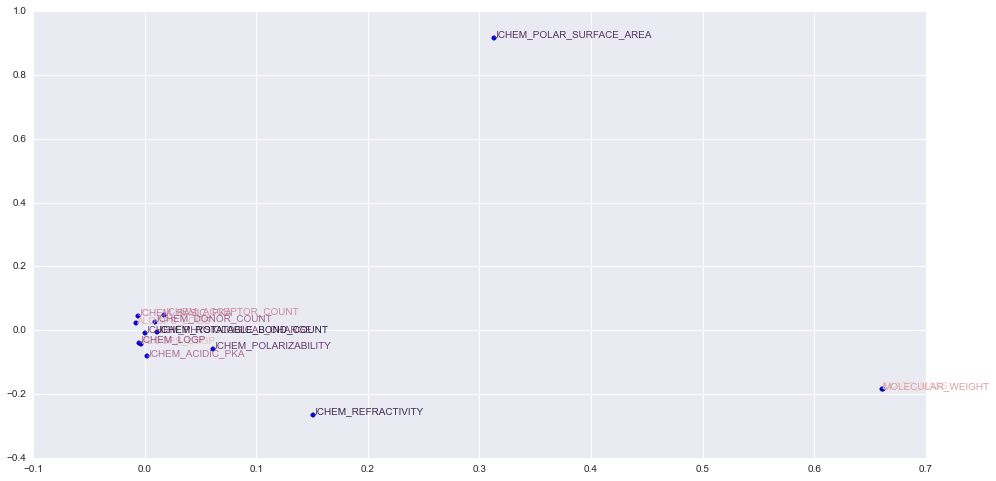

In [7]:
fig, ax = plt.subplots()

plt.scatter(pca.components_[0], pca.components_[1])
colors = sns.cubehelix_palette(len(features))

for x, y, label, c in zip(pca.components_[0], pca.components_[1], features, colors):
    ann = ax.annotate(label, (x, y), color=c)

plt.grid(True)
plt.show()

# Feature Clusters

In [8]:
X = pca.components_[0]
Y = pca.components_[1]

df = DataFrame({'X': X, 'Y': Y, 'LABEL': features})

In [9]:
N_CLUSTERS = 4

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(df[['X', 'Y']])

clusters = Series(kmeans.predict(df[['X', 'Y']]), name='CLUSTER')
                  
df_grouped_features = pd.concat([df, clusters], axis=1)
df_grouped_features.sort(columns=['CLUSTER'], ascending=True, inplace=True)

df_grouped_features

,LABEL,X,Y,CLUSTER
1,ALOGPS_LOGP,-0.003007,-0.042943,0
2,ALOGPS_LOGS,-0.007602,0.021434,0
4,JCHEM_ACCEPTOR_COUNT,0.017052,0.049011,0
5,JCHEM_BASIC_PKA,-0.005765,0.045393,0
6,JCHEM_ACIDIC_PKA,0.002191,-0.082056,0
7,JCHEM_DONOR_COUNT,0.009637,0.025682,0
8,JCHEM_LOGP,-0.005313,-0.039045,0
9,JCHEM_PHYSIOLOGICAL_CHARGE,-0.000124,-0.008141,0
10,JCHEM_POLARIZABILITY,0.061501,-0.058164,0
13,JCHEM_ROTATABLE_BOND_COUNT,0.010898,-0.006098,0
